# ProjectPegasus

Exam project for the Artificial Intelligence Fundamentals course, a.y. 2023/2024

Notebook and code by the NetRiders team: Giordano Scerra, Andrea Marino, Yuri Ermes Negri, Davide Borghini, Davide Marchi

---

## Introduction

This project focuses on the task of riding a pony. To do so, the agent:
- Picks up some carrots
- Feeds the pony with carrots, to pacify it and increase its tameness
- Looks for a saddle
- Applies the saddle on the pony and rides it
- If it deems so, fights monsters and hunger


Those listed here are not only necessary steps to perform the task successfully, but also *subtasks* on their own. As it will be thoroughly described later, the task is solved by continuously selecting the most appropriate subtask and executing it, given the state of the environment at a given moment. The execution of the subtask is controlled by a knowledge base which is updated it with the changes that are applied to the environment.

## Methodologies

Our code is structured in three main files:
- **Map.py**: These class' methods are used for the interactions with the environment: extracting information from the cells, rendering the level and making a proper step in the game (i.e. applying the actions).
- **Agent.py**: Interacts with Map.py and the knowledge base with two methods: `percept()` and `act()`. 
    - `percept()`: reads information from the environment - using attributes from Map - and populates the knowledge base, using methods from the KBwrapper.
    - `act()`: queries the knowledge base for the best subtask to execute and launch the related methods.
- **KBwrapper.py**: For the agent, its knowledge base is an instance of this class. Based on pyswip library, its methods are used to manage the "kb.pl" Prolog knowledge base by asserting, retracting and querying the appropriate predicates. 

### Subtasks and Interrupts

Because of the non-deterministic nature of our environment, we decided to implement an intelligent system for decision making based on interruptions. As already mentioned, the `agent.act()` queries the knowledge base for the best subtask to perform among these ones:
- *getCarrot* : to go and collect the nearest carrot
- *getSaddle* : to go and collect the saddle, which is necessary to ride the pony 
- *feedSteed* : to feed the the pony by throwing carrots at it
- *applySaddle* : to apply the saddle to the pony
- *rideSteed* : to attempt to ride the pony
- *explore* : to explore unseen zones of the map
- *attackEnemy* : go towards an enemy and make a single attack at it
- *eat* : take an item from the inventory and eat it to sate the agent's hunger or cure it from blindness


Of course, each subtask, consisting in a high level action, requires the agent to undertake a sequence of primitive actions. After a primitive action is performed (which implies that a step is made), the knowledge base is queried again for an interruption signal, whose purpose is to notify the agent that the premises to continue that specific subtask are no longer valid (for example, a contingency may have happened) and a subtask switch is needed. In particular, after every step the agent makes in the environment (basically after every `env.step`), the premises for the interruption of the current subtask are checked, and if satisfied the flow of actions required to perform the subtask is interrupted. After that, the knowledge base is queried again for the best subtask to perform next, effectively changing its planning.

We drew inspiration for the basic functioning of the agent in our project from the *knowledge_base_agent* paradigm that we saw during the course. In fact, whenever the agent has to do an action, it first senses the environment by calling the `percept()` method, which acts as a TELL, then performs an action, and finally queries the knowledge base for an interruption. Hence the ASK part is done in a two-fold way by both the interruption query and by the subtask query. What differs from the knowledge base seen in the course is that ours tells the agent to execute subtasks, which are composed of primitive actions, instead of primitive actions themselves.

We thought that this approach is both necessary for the task at hand, as the environment changes repeatedly and unpredictably due to things such as the activity of the pony and monsters, and interesting to see in action.


### Knowledge Base

As discussed during the oral presentation, and as described in the previous paragraph, the knowledge base is where both the information is stored and the decision making process for the agent takes place. This entity itself is divided in two parts, which can be distinguished by the two different languages in which they're written: Prolog and Python. In fact, Python is used as a wrapper interface to control the Prolog part, thanks to the open source library pyswip.
The subtasks in the knowledge base are defined in order of relevance. We have:
- getCarrot
- feedSteed
- getSaddle
- applySaddle
- explore (chosen when no premise is satisfied for another subtask to start)
- eat
- attackEnemy


After the subtask's section, in our code we have the interruption's section. Here we can find, for every subtask, its own interruption clause. Then we have some known facts, like the pony's maximum possible tameness assigned to 20, or the definition of a steed. Eventually, there is a section where we store some observations like the number of carrots or saddles in our possession, or the pony's current tameness. 

In the (rare) case where the agent has no better action than 'explore' and it performs 1 full map patrol, the subtask switches to riding. This was implemented to avoid endless exploring, it's a desperate last resort option.

The first subtask that is listed in the knowledge base is `action(attackEnemy)`, which can be entailed if `attack(enemy,_)` can be entailed. This counterintuitive syntax is a workaround to maintain the compatibility with the way that the `Agent.act()` method selects the other subtasks while maintaining the possibility to query which enemy to attack. This information is necessary to execute the *attackEnemy* subtask, and is better provided by the knowledge base; on the other hand the other subtasks don't have arguments tied to logic variables of any sort, since they don't need them: all the relevant information such as which is the closest element to reach is more easily provided by processing through python the information present in the knowledge base or other data structures.

*attackEnemy* is the first that is listed as we wanted it to be at higher priority, in the case that it could be inferred together with some other subtask. For the task at hand, the subtasks can be totally ordered (in the sense of preference) if no complications arise: the ideal plan should be *getCarrot*, *feedSteed*, *getSaddle*, *applySaddle*, *rideSteed*. The *attackEnemy* and *eat* subtasks are contingency plans while *explore* is a last resort. It is natural that the first two are prioritized above anything else if there is an interruption, and that the latter has least priority.

We took inspiration from the second hands-on session for the knowledge base, even reusing some of the predicates, but we heavily modified it for our needs. 


### Subtasks structure and A*

At a higher level, almost all the subtasks are performed in the same way: go to the closer specified element and interact with it by applying an action. The latter part is managed by the `Agent.perform_action()` method, while for the former part we used A*. This algorithm is well suited for targets that are static, but sometimes the agent has to go towards elements that change their position in the map (e.g. moving enemies, ponies). This problem was resolved by considering only the first step of the entire A* path, reiterated repeatedly according to the new target position.

So all of these subtasks share the same underlying structure, changing just a few parameters. 
There is a subtask that is a little different: the `explore` subtask. It chooses an unseen cell using an heuristic to determine which to pick among the non visited ones. Like the other high level actions,`explore` uses A* to compute the path to the chosen cell. When executing the path the agent also checks that nothing may block its movement to avoid wasting steps. After the agent has seen a new cell it picks another cell and repeats the process.
The subtask ends after an interruption (which in turn is given if the agent sees something interesting) or when it does a full visit of the map without being interrupted.

We took the code of the A* algorithm from the handson session 1, and modified it for our needs.


## Live demo

Let's see a small demo of our project. In order to run the following code, and in general to replicate our work, make sure that:
1. this notebook stays inside the folder in which it was delivered. This is necessary to resolve the imports
2. the following packages that were used in the hands-on sessions are installed: `pyswip`, `minihack`, `numpy`, `nle`, `matplotlib`, `notebook` 

Let's first import the classes that were described in the previous sections, and that are used in all the tests

In [ ]:
from utils.map import Map
from utils.agent import Agent

We implemented three distances, to test them as heuristics for the A* algoritm. We ran all of our tests using `manhattan_distance`, but other heuristics can be tried out by passing them as parameters to `agent.act()`

Of course, the correctness of the algorithm is independent from the used heuristic, as long as it is a correct one.

In [ ]:
from utils.heuristics import manhattan_distance, infinity_distance, euclidean_distance
heuristic = manhattan_distance

We provided plenty of examples to explore, and a lot of parameters to set at will. Let's create a simple map in which there are three enemies (a lichen, a jackal and a newt), an untamed pony and a saddle.

Let's also create the agent, and first sense the environment.

In [ ]:
level = Map(level=3, enemies=True)

steinbeck = Agent()
steinbeck.percept(game_map=level)

Let's display the map...

In [ ]:
# the graphic=True can be used only if level in [0,1,2,3] in the Map class
level.render(graphic=True)

... and run the example. This is as simple as asking the agent to act in the environment.

In [ ]:
while(not level.is_episode_over()):
    steinbeck.act(level, show_steps=True, graphic=True, delay=0.1)

Let's see how well our agent performed in this level

In [ ]:
print(sum(level.rewards))

Here, we sum all the rewards coming from the events we created.

First of all, why a sum? 
Since we decided to append the reward assigned in each state of the environment to a list, we end up with a pretty long one, especially in gargantuan mazes.
The events we defined and chose to record are `getCarrots` and `MountEvent` which respectively assign a reward of one point for picking up a carrot and 1000 points for mounting the steed.

We discussed extensively about using an event that'd give off a reward of -1 for each step taken by the agent and came to the conclusion that it would be inadequate for our task: we wished to face multiple contingencies while taming the steed: fighting a monster in our path to a carrot or near the steed, finding all the carrots, getting the steed to drop the saddle if it ever wished to take it and many more. Because of this, using such a reward would have pushed us to solve the task *faster* instead of *better*, becoming a sort of toxic inductive bias on our work: we'd have been more focused on finding good heuristics to finish the level in time instead of solving the many problems we had to face. 
Also, since the maps can be different both in size and complexity, adding such a metric would meddle the evaluations of the performance of our agent: on bigger, more difficult maps to cross and explore, the agent would forcibly be penalized even if it managed to find all the carrots (which maximize its probability to apply the saddle to the pony and mount it), kill any monster that put it or its steed in danger or even cure itself from blindness or the hunger states.

## Assessment

To face the variance induced by the fact that every element in the map (carrots, saddle, horse and monsters) spawns randomly (as well as the agent, sometimes), we iterated many tests and made our assessment over their results. \
The heuristics we chose to compare are the `Manhatthan distance` and the `Infinity distance`, which will be evaluated on level 2 and 3, representing a level that better resembles the NetHack maps and a quite intricate maze, respectively. \
The general behaviour of the agent has been tested over the levels 0, 1, 2, 3 and -1, which is a level where the agent is randomly put in a randomly spawned maze. Level 0 represents a small, rectangular room while level 1 is composed by two different rooms, connected by a narrow corridor. Furthermore, we evaluated the behavior of our agent under varying degrees of problem relaxation by testing it both with and without the contingencies presented by hunger and monsters.

We will now present two histograms, one indicating the medium steps on a success and failure scenario, while the other indicates the success rate of our agent in a certain level with certain conditions.
The naming convention we devised for the different evaluation environments is given by the concatenation of these elements:
- L
- a number between -1 and 3 to indicate the level
- Y or N to indicate presence or absence of a certain contingency, respectively
- A, which is the initial of "Apples" (eaten by our agent): indicates the contingency of hunger 
- Y or N to indicate presence or absence of a certain contingency, respectively
- E, which is the initial of "Enemies"

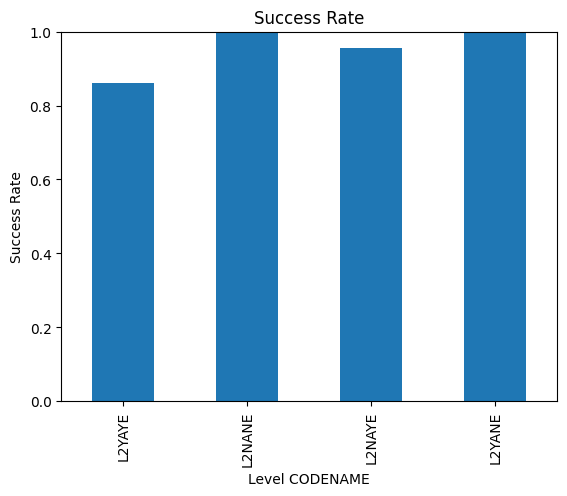

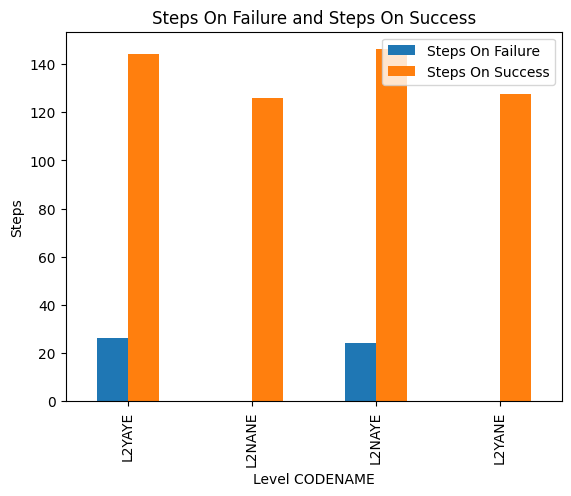

In [7]:
from stats.show_stats import show_stats

# -1 for random maze
# 0 for square
# 1 for impossible one
# 2 for nethack-like level
# 3 for complex maze

show_stats(level=2, success_rate_flag=True)

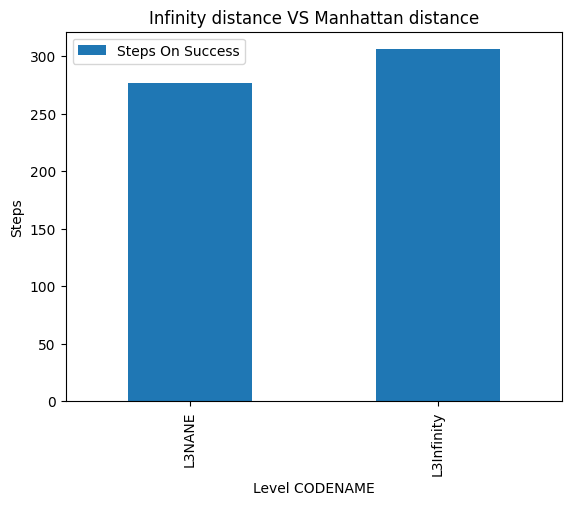

In [3]:
from stats.show_stats import compare_heuristics

# 2 for nethack-like level
# 3 for complex maze

compare_heuristics(level=3)

## Conclusions

We have seen that adding contingencies, as expected, hinders the capability of our agent to solve the task. In particular, the relationship between the chances of success and the addition of monsters to the map underlines the danger posed by combat at the early stages of the game (our knight starts at level 1) and the need for a more conservative approach when dealing with such contingencies. \
As the dungeons grew deeper and darker, our agent started to suffer from hunger while it meticolously searched for the carrots required to feed its steed. Eating, as it surfaces from the tests, does not negatively impact on the performance of our agent. We inferred that it didn't hinder the capability of our agent to solve its task because the subtask of eating makes the agent lose two turns at worst (one to eat an apple that blinds it, one to eat a carrot to cure itself) but is mainly executed in big, complex environments in which it is almost inconsequential to spend one or two turns standing still. 

---

## Appendix

Our project is related with the course for these key topics:
- **A\* search algorithm**: we implemented A* to approach every element in the map and explore its every nook! We tried out different heuristics to assess their efficiency alongside it.
- **Knowledge Base**: Our agent relies on a Knowledge Base to keep track of the environment that surrounds it, which is non-deterministic, and to remember basic but important things such as the category of the monsters it encounters, some rules of the game and directionality.
- **High Level Actions and Contingency planning in a non-deterministic environment**: We decided to implement an agent that infers from its Knowledge Base subtasks, which by many aspects resemble HLAs, that complete particular, articulated tasks to reach a final state (the pony mounted) until a contingency is detected (through the agent's percepts) and the plan of the agent changes to reach its goal state.


The github repository can be found [here](https://github.com/giordanoscerra/ProjectPegasus)

The statistics that can be easily seen from the repository certify that all the team members were highly involved in the project in terms of code submission and time spent programming. Even though the number of commits from the various members is uneven, all of us contributed to the project significantly, often in other aspects such as maintaining the repository, planning of the project, giving new ideas, proposing new approaches, discussing pull requests and so on.

In addition to all of that, our team had real-life meetings to discuss which task to face and had many sessions over Discord in which we jointly wrote code and discussed how to develop, fix and tackle the different problems that arose during our work.
